In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [6]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]
        self.transform = T.Resize((512, 512))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        image = read_image(os.path.join(self.data_dir, file_name + ".png"), mode=ImageReadMode.RGB)

        # read mask
        mask = read_image(os.path.join(self.label_dir, file_name + ".png"), mode=ImageReadMode.GRAY)

        # resize
        image = self.transform(image)
        mask = self.transform(mask)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        image = image / 255.0
        mask /= 255.0
        mask = torch.round(mask)

        return image, mask



ds = Dataset("./test", "./labels")
ds_loader = DataLoader(ds, batch_size=4)

In [7]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x



class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 16)
        self.e2 = encoder_block(16, 32)
        self.e3 = encoder_block(32, 64)
        self.e4 = encoder_block(64, 128)

        """ Bottleneck """
        self.b = conv_block(128, 256)

        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        self.d4 = decoder_block(32, 16)

        """ Classifier """
        self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 512, 512)).to(device)
model = build_unet().to(device)
y = model(inputs)
print(y.shape)

torch.Size([2, 1, 512, 512])


In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [9]:
num_epochs = 200

for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(ds_loader):
        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Lote:", idx)

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



C:\Users\judpo\AppData\Local\Temp\ipykernel_14640\1878809580.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\judpo\AppData\Local\Temp\ipykernel_14640\1878809580.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/200], Loss: 0.2267
Lote: 0
Epoch [2/200], Loss: 0.1575
Lote: 0
Epoch [3/200], Loss: 0.1218
Lote: 0
Epoch [4/200], Loss: 0.0992
Lote: 0
Epoch [5/200], Loss: 0.0823
Lote: 0
Epoch [6/200], Loss: 0.0691
Lote: 0
Epoch [7/200], Loss: 0.0544
Lote: 0
Epoch [8/200], Loss: 0.0497
Lote: 0
Epoch [9/200], Loss: 0.0408
Lote: 0
Epoch [10/200], Loss: 0.0409
Lote: 0
Epoch [11/200], Loss: 0.0310
Lote: 0
Epoch [12/200], Loss: 0.0247
Lote: 0
Epoch [13/200], Loss: 0.0241
Lote: 0
Epoch [14/200], Loss: 0.0220
Lote: 0
Epoch [15/200], Loss: 0.0186
Lote: 0
Epoch [16/200], Loss: 0.0151
Lote: 0
Epoch [17/200], Loss: 0.0155
Lote: 0
Epoch [18/200], Loss: 0.0135
Lote: 0
Epoch [19/200], Loss: 0.0109
Lote: 0
Epoch [20/200], Loss: 0.0107
Lote: 0
Epoch [21/200], Loss: 0.0104
Lote: 0
Epoch [22/200], Loss: 0.0089
Lote: 0
Epoch [23/200], Loss: 0.0079
Lote: 0
Epoch [24/200], Loss: 0.0071
Lote: 0
Epoch [25/200], Loss: 0.0069
Lote: 0
Epoch [26/200], Loss: 0.0063
Lote: 0
Epoch [27/200], Loss: 0.0057
Lote: 0
Ep

C:\Users\judpo\AppData\Local\Temp\ipykernel_14640\1878809580.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\judpo\AppData\Local\Temp\ipykernel_14640\1878809580.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


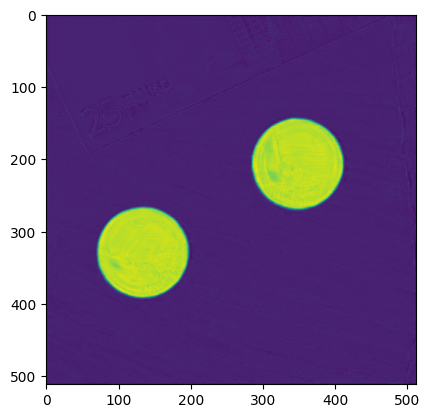

In [10]:
it = iter(ds_loader)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

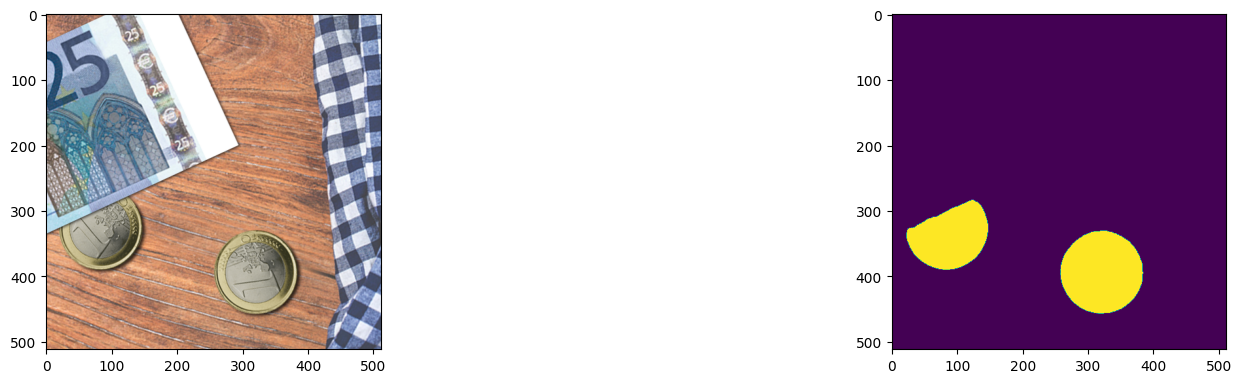

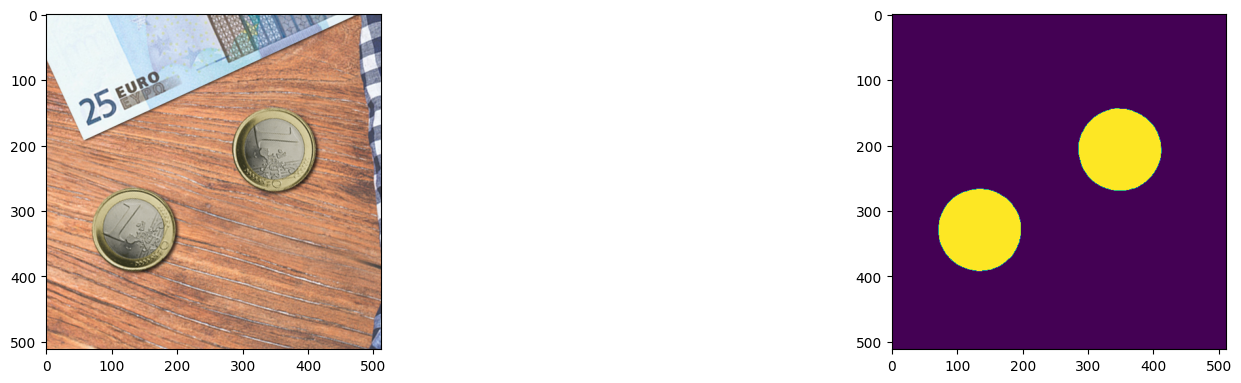

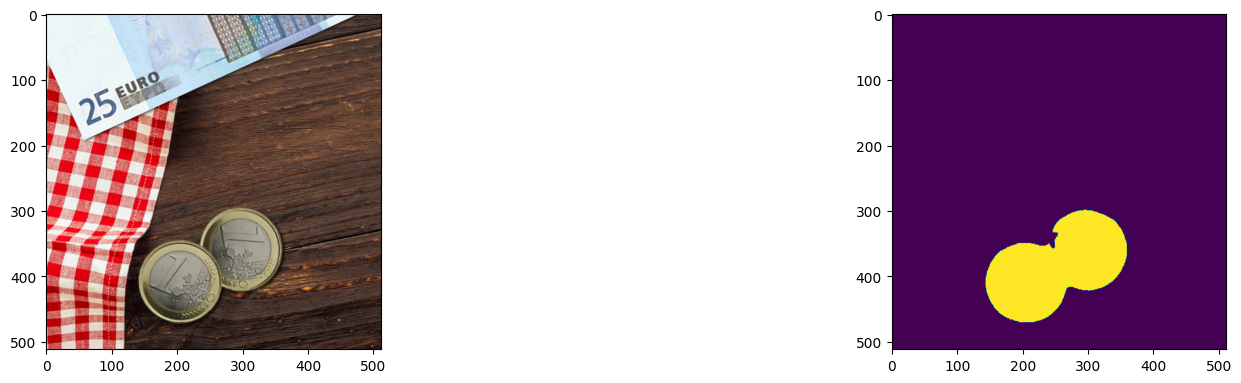

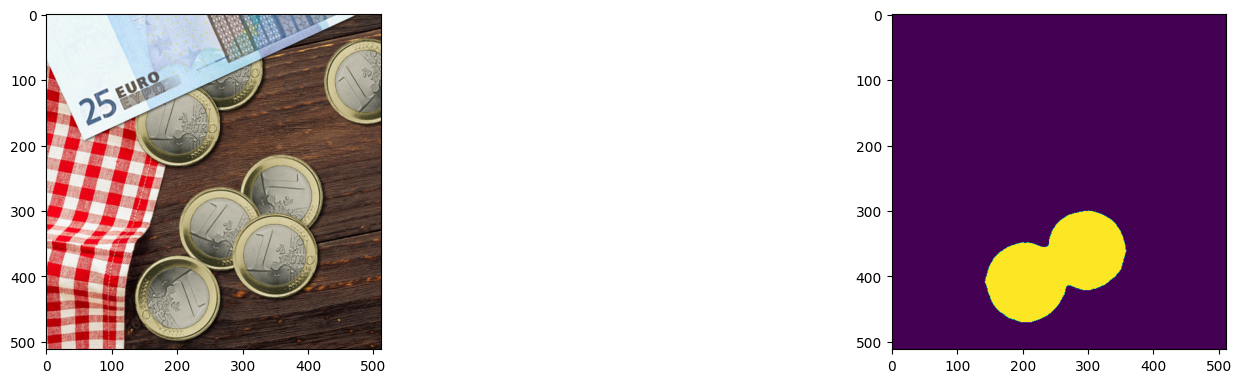

In [11]:

# Threshold the output
ret = torch.round(ret)

# Show a matrix of images of 4x2
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())


In [12]:
torch.save(model.state_dict(), "model_unet_coins.pth")

In [13]:
#model = build_unet()
model.load_state_dict(torch.load("model_unet_coins.pth"))

<All keys matched successfully>